---

**name: Brooke Ryan**

**SID: 51809437**

---

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import ndimage
from scipy.signal import convolve2d
import maxflow
from scipy.cluster.vq import kmeans, whiten
from scipy import spatial
from selectpoints import select_k_points as select_k_points
from PIL import Image, ImageStat
from skimage.color import rgb2gray

# Color Quantization

k-means clustering can be used to reduce the color
palette of an image.  Write a function that takes a color image and a value for
$k$ and returns a new version of the image which uses only $k$ distinct colors.
Your code should cluster the pixel color values using k-means and then produce
a new image where each pixel is replaced with the color of the closest cluster center.

You are welcome to use the **kmeans** function provided by **scipy**.
Demonstrate your code on the provided "*rainbow*" image for different values of $k =
{2,5,10}$.  Describe how the clustering changes if you scale one of the feature
coordinates, say the $R$ (red) value by a factor of $1000$?  Specifically, you can test this
by first multiplying the $R$ channel by 1000 and performing the clustering and
then dividing the R channel in the resulting quantized image by 1000 prior to
displaying it.

In [88]:
def normalize(image):
    """
    Transform PIL.Image into normalized float numpy array
    :param image: PIL Image
    :return: float numpy array
    """
    return np.asarray(image, dtype=np.float64)/255

def scale(image, factor=1000):
    """
    Sclaes the R band by a given factor
    :param image: PIL.Image
    :param factor: Default is 1000.
    :return: scaled image
    """
    image_arr = normalize(image)
    image_arr[:, :,0] *= factor
    return image_arr

def rescale(image, factor=1000):
    """
    Rescales the R band by a given factor
    :param image: PIL.Image
    :param factor: Default is 1000.
    :return: rescaled image
    """
    image[:, :,0] /= factor
    return image

def color_quantization(image, k, scale_R=False):
    """ takes a color image and a value for k and returns a new version of the image which uses only k distinct colors.
    :param image: a color image
    :param k: value for k in k-means clustering
    :param scale_R: Default is False. True will call scale function on R channel.
    :return: a new image where each pixel is replaced with the color of the closest cluster center
    """
    # Scales the R channel
    if scale_R:
        image = scale(image)
    else:
        # Transform into float numpy array
        image = normalize(image)

    # Obtain image dimensions
    w, h, d = image.shape

    # Reshape image to be a 2d array to perform k-means
    colors, _ = kmeans(np.reshape(image, (w * h, d)), k)

    # new k colors image in the shape of the original image
    k_colors_image = np.zeros((w, h, d))

    # Assign pixels in original image to closest color from centroids
    for i in range(w):
        for j in range(h):
            distance = spatial.distance.cdist(colors, image[i, j].reshape(-1,3))
            k_colors_image[i, j] = colors[np.argmin(distance)]

    return k_colors_image, colors

## Original Image

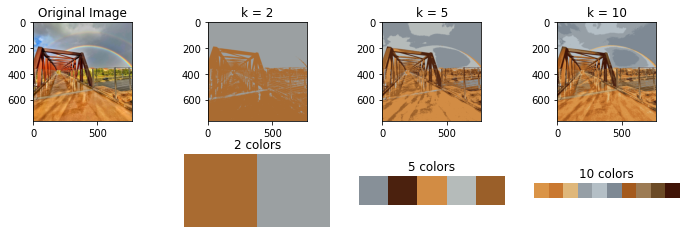

In [89]:
k = [2, 5, 10]
fig, ax = plt.subplots(2, 4, figsize=(12, 4))
image = Image.open("rainbow_bridge.jpg")

ax[0,0].imshow(image)
ax[0,0].set_title("Original Image")
ax[1,0].set_visible(False)

for i, k in enumerate(k):
    img, colors = color_quantization(image, k)
    ax[0, i+1].imshow(img)
    ax[0, i+1].set_title("k = {k}".format(k=k))
    ax[1, i+1].imshow(colors[np.newaxis, :, :])
    ax[1, i+1].axis('off')
    ax[1, i+1].set_title("{k} colors".format(k=k))

## Scaled and Rescaled Image

In [ ]:
k = [2, 5, 10]
fig, ax = plt.subplots(2, 4, figsize=(12, 4))
image = Image.open("rainbow_bridge.jpg")

ax[0,0].imshow(scale(image))
ax[0,0].set_title("Scaled Image")
ax[1,0].set_visible(False)

for i, k in enumerate(k):
    img, colors = color_quantization(image, k, scale_R=True)
    ax[0, i+1].imshow(rescale(img))
    ax[0, i+1].set_title("k = {k}".format(k=k))
    ax[1, i+1].imshow(colors[np.newaxis, :, :])
    ax[1, i+1].axis('off')
    ax[1, i+1].set_title("{k} colors".format(k=k))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Scaled Image, not Rescaled

In [ ]:
k = [2, 5, 10]
fig, ax = plt.subplots(2, 4, figsize=(12, 4))
image = Image.open("rainbow_bridge.jpg")

ax[0,0].imshow(scale(image))
ax[0,0].set_title("Scaled Image")
ax[1,0].set_visible(False)

for i, k in enumerate(k):
    img, colors = color_quantization(image, k, scale_R=True)
    ax[0, i+1].imshow(img)
    ax[0, i+1].set_title("k = {k}".format(k=k))
    ax[1, i+1].imshow(colors[np.newaxis, :, :])
    ax[1, i+1].axis('off')
    ax[1, i+1].set_title("{k} colors".format(k=k))

## Discussion
> Describe how the clustering changes if you scale one of the feature coordinates, say the (red) value by a factor of 1000?

In the first experiment with the original image, where none of the color channels are scaled, the results turn out how
we would expect them to. The most common colors in the image are found, and then each pixel is re-assigned to its closest
$k$ color.

In the second experiment with the scaled image, the results are not quite as intuitive.
As we can clearly see in the color palettes below the image, the $k$ most common colors that are found are taken from the
scaled image. So they all are peaches, oranges, and reds. Take the $k=2$ plot, for instance. It is clear that the orange color
in the palette maps to the bridge. Apparently, the peach color has mapped to the sky. In the output image,
though, the sky appears to be gray. I postulate this is because when the final image is shown, the red is
significantly "drained" from the image. Although the orange color doesn't look too different, the peach one is closer to gray
because pink is a mixture of red and white. I conducted a third experiment with the scaled image and then the output image
is not rescaled to communicate this finding.

# Texture Modeling

## Filterbank

In order to analyze texture, we would like to describe the
image in terms of distributions of filter outputs.  Implement a filter bank
function which takes an image as input and filters the image with Gaussian
derivatives in the horizontal and vertical directions at 3 different scales
${\sigma = 1,2,4}$.  Also create an additional center surround filter by taking
the difference of two isotropic Gaussian functions at two different scales, e.g.
$G_2(x,y)-G_1(x,y)$ and $G_4(x,y) - G_2(x,y)$.

Your filterbank function should take as input one grayscale image and return 8
filter response images.

### Implementation

In [ ]:
def gaussian(x, y, sigma):
    """
    Computes a Gaussian convolution kernel.
    sigma : standard deviation for Gaussian kernel.
    :return: gaussian, gaussian_dx, gaussian_dy
    """
    return (1/(2*np.pi*sigma**2)) * np.exp(-(x**2 + y**2)/(2*sigma**2))


def gaussian_dx(x, y, sigma):
    """
    Gaussian derivative with respect to x.
    """
    return ((-x)/(sigma**2)) * gaussian(x, y, sigma)


def gaussian_dy(x, y, sigma):
    """
    Gaussian derivative with respect to y.
    """
    return ((-y)/(sigma**2)) * gaussian(x, y, sigma)


def blank_filter(sigma=3, scale=5):
    """
    Creates space upon which to later implement Gaussian filters.
    :param scale: For Gaussian filters you typically want to choose the size of the filter to roughly 5 or 6 times the value of sigma.
    :param sigma: average value (approx) of three sigma values [1,2,4]
    :return: x,y
    """
    d = np.linspace(-scale*sigma, scale*sigma)
    return np.meshgrid(d, d)


def filter_kernels():
    """
    Creates the 8 filter kernels.
    :return: filters
    """
    filters = []
    gaussians = []

    for sigma in [1, 2, 4]:
        x, y = blank_filter()
        gaussians.append(gaussian(x, y, sigma))
        filters.append(gaussian_dx(x, y, sigma))
        filters.append(gaussian_dy(x, y, sigma))

    # Center surround filters
    g2_g1 = gaussians[1] - gaussians[0]
    g4_g2 = gaussians[2] - gaussians[1]

    filters.append(g2_g1)
    filters.append(g4_g2)

    # Sanity check
    assert len(filters) == 8

    return filters


def filterbank(image):
    """
    Takes an image as input and filters the image with Gaussian derivatives in the horizontal and vertical directions at 3 different scales sigma=1, 2, 4.
    Also creates an additional center surround filter by taking the difference of the two isotropic Gaussian functions at 2 different scales.
    :param image: Grayscale image
    :return: 8 filter response images
    """
    filters = filter_kernels()
    filter_bank = []

    for filter in filters:
        filter_bank.append(convolve2d(image, filter, mode='same'))

    return filter_bank

### Visualization
Visualize the kernels of your 8 filters as images using a pseudocolor colormap.

In [ ]:
filters = filter_kernels()
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

titles = ["dx sigma = 1", "dy sigma = 1", "dx sigma = 2", "dy sigma = 2", "dx sigma = 4", "dy sigma = 4", "G2 - G1", "G4 - G2"]

for ax, filter, title in zip(axs.ravel(), filters, titles):
    ax.imshow(filter, cmap='jet')
    ax.axis('off')
    ax.set_title(title)

### Filter Statistics
Apply your filter bank to a test image of your choice.

In [ ]:
image = Image.open("zebra_small.jpg").convert('L')
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
filter_bank = filterbank(image)

for ax, filter, title in zip(axs.ravel(), filter_bank, titles):
    ax.imshow(filter, cmap='gray')
    ax.axis('off')
    ax.set_title(title)

Plot a histogram of each of the individual filter responses on a semi-log plot (i.e., where the x-axis is the value of the filter response and the y-axis is the *log* of the number of pixels that took on that value).

You can use **np.histogram** to compute the histograms and plot them all on the same axis.

Choose the number and range of bins which gives a nice smooth, high-res curve.

#### Same Axis

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
histograms = {}

for f, title in zip(filter_bank, titles):
    histograms[title] = np.histogram(f, bins='auto')

# Setting in particular order for maximum visibility of all graphs.
ordered_titles = ["dx sigma = 1", "dy sigma = 1", "G2 - G1", "G4 - G2", "dx sigma = 2", "dy sigma = 2", "dx sigma = 4", "dy sigma = 4"]

for t in ordered_titles:
    counts, bins = histograms[t]
    axs.hist(bins[:-1], bins, weights=counts, label=t)

plt.yscale('log')
plt.legend()

#### Separate Axes
Plotting on separate axes for clarity.

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
histograms = {}

for f, title in zip(filter_bank, titles):
    histograms[title] = np.histogram(f, bins='auto')

for ax, title in zip(axs.ravel(), titles):
    counts, bins = histograms[title]
    ax.hist(bins[:-1], bins, weights=counts, label=title)
    ax.set_title(title)
    ax.set_yscale("log")

#### Compare to lecture slides
> How do they compare to the distributions shown in the lecture 8 slides?

The distributions follow a similar pattern as the ones shown in the lecture 8 slides.
From the slides, as the sigma value gets larger, the more concentrated and narrow the response looks, which appears to correlate with what we see in the histograms plotted on the same axes. Additionally, the filter responses all peak around 0, which also corresponds to what we see in the lecture slides.

## Texture Analysis

Select an image patch (say 40x40 pixels) over the zebra's neck, in the tree
leaves above the zebra's back, and also on the grass in front of the zebra.

Compute the mean absolute response of each of the 8 filter responses over that region
(if you don't take an absolute value then the positive and negative
components will tend to cancel out and give you mean 0).

This will give you a vector of 8 numbers that summarize the patch texture.

In [ ]:
def mean_absolute_response(image):
    """
    Compute the mean absolute response of each of the 8 filter responses.
    :param: image: Grayscale image
    :return: vector of 8 numbers that summarize the patch texture.
    """

    filters = filterbank(image)

    mean_absolute_responses = []

    for filter in filters:
        mean_absolute_responses.append(np.mean(np.abs(filter)))

    return mean_absolute_responses


In [ ]:
def plot_mean_absolute_responses(icons, d):
    neck, grass, tree_leaves = icons
    icon_titles = ["Zebra Neck ({d})".format(d=d), "Grass ({d})".format(d=d), "Tree Leaves ({d})".format(d=d)]
    mars_list = [mean_absolute_response(neck), mean_absolute_response(grass), mean_absolute_response(tree_leaves)]
    fig, ax = plt.subplots(2, 3, figsize=(20, 15))

    for i, icon, it, mars in zip(range(3), icons, icon_titles, mars_list):
        ax[0, i].imshow(icon, cmap='gray')
        ax[0, i].set_title(it)
        ax[0, i].axis('off')

        ax[1, i].set_title("{it}; Mean Absolute Responses".format(it=it))
        ax[1, i].xaxis.set_visible(False)

        for w, mar, t in zip(range(8), mars, titles):
            ax[1, i].bar(w, mar, label=t)

        ax[1, i].legend()

### 40 $\times$ 40 Patches

In [ ]:
# Small 40 x 40 sample icons
dimensions = "40 x 40"
icons_40_40 = [
    Image.open("zebra_neck.jpg").convert('L'),
    Image.open("grass.jpg").convert('L'),
    Image.open("tree_leaves.jpg").convert('L')
]
plot_mean_absolute_responses(icons_40_40, dimensions)

### 100 $\times$ 100 Patches

In [ ]:
dimensions = "100 x 100"
icons_100_100 = [
    Image.open("neck_100.jpg").convert('L'),
    Image.open("grass_100.jpg").convert('L'),
    Image.open("leaves_100.jpg").convert('L')
]
plot_mean_absolute_responses(icons_100_100, dimensions)

### 10 $\times$ 10 Patches

In [ ]:
dimensions = "10 x 10"
icons_10_10 = [
    Image.open("neck_10.jpg").convert('L'),
    Image.open("grass_10.jpg").convert('L'),
    Image.open("leaves_10.jpg").convert('L')
]
plot_mean_absolute_responses(icons_10_10, dimensions)

### Discussion
> Visualize (e.g., using the **plt.bar** function) the three mean
response vectors for these regions and explain the differences you see in terms
of your filters. You may need to experiment with resizing
image to find the best scale at which to capture the texture. In your writeup,
explain how you chose the scale.

The general pattern that I observe is that the filters with the highest mean absolute response is correlated to the most prominent texture that is observed in the image.
For instance, in the 40x40 Zebra neck patch, we see that the highest response is the Gaussian derivative with respect to $x$.
This corresponds with what we expect because the stripes are primarily vertical in this image. Also, since a lower sigma value tends to identify more fine lines, this also aligns with the highest response being correlated with the lowest sigma value.
In the 10x10 zebra neck patch however, although it is focused around the same general area, the filters are not able to as easily identify those vertical lines, and as such, we do not see $dx$ as the highest response.
In terms of scale, three different dimensions were chosen for the patches and explored in the experiments above: 40x40, 100x100, and 10x10.
For this particular image, it appears as though the 40x40 responses best correlate with the given patches. The 100x100 patches are too large and capture unwanted details outside of the intended theme of the icon.
The 10x10 patches though are too small and do not capture enough detail.

## 3. Segmentation with Markov Random Fields

In this problem you will build a Markov Random Field model for interactively
segmenting an image into foreground/background and use an `st-mincut` solver to
find the MAP assignment of pixels to foreground and background.

We will use PyMaxflow which implements the mincut solver. You can find some 
tutorial documentation here:  http://pmneila.github.io/PyMaxflow/tutorial.html

You will need write code that loads in an image and computes the appropriate
weights between neighboring pixels as well as the edge connections to the `s` and
`t` nodes.

Your code should display the image and prompt the user to click on two seed
points for foreground and background. I've provided a function to allow this
in your notebook (**selectpoints.py**).

You should use these seed points to do two things:
1. First, use the color of  the pixels in the vicinity of the two points to initialize
the foreground and background color models.
2. Second, set the st-connections so that these seed points are constrained to be in
the foreground and background of the final solution (i.e., give them large weights).

Build a model in which the foreground and background are assumed to
be constant color.  Your `st` edges should have weights which are proportional to
the distance in RGB between the pixel and your foreground or background color.
Connections between neighbors should be proportional to the difference in
color between neighboring pixels.  There is a free parameter $\lambda$ in eqn
1 of the paper by Boykov \& Jolly paper (linked on the course website) that controls
the relative importance of the st edges and the neighbor edges in the graph.
You will want to experiment to find a setting of this parameter that gives you
a good segmentation result for the test image.

## 3.1 Implementation

In [ ]:
%matplotlib widget
from imageio import imread

# use an st-mincut solver to find the MAP assignment of pixels to foreground and background

# With the seed points:
#    1. Use the color of the pixels in the vicinity of the two points to initialize the foreground and
#    background color models.
#    2. Set the st-connections so that these seed points are constrained to be in the foreground and
#    background of the final solution.

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

def difference_pixels(pixel_1, pixel_2):
    """
    Computes the difference between two neighboring pixels. 
    Uses the Euclidean distance formula.
    """
    # Color 1
    color1_rgb = sRGBColor(pixel_1[0], pixel_1[1], pixel_1[2])

    # Color 2
    color2_rgb = sRGBColor(pixel_2[0], pixel_2[1], pixel_2[2])

    # Convert from RGB to Lab Color Space
    color1_lab = convert_color(color1_rgb, LabColor)

    # Convert from RGB to Lab Color Space
    color2_lab = convert_color(color2_rgb, LabColor)

    # Find the color difference
    delta_e = delta_e_cie2000(color1_lab, color2_lab)

    print("The difference between the 2 color = ", delta_e)
    

def get_seed_points(image_path):
    """
    1. Display the image
    2. Prompt user to click on two seed points for foreground and background using selectpoints
    :param image:
    :return: seed points
    """
    image = plt.imread(image_path)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.imshow(image, cmap='gray')
    return select_k_points(ax,2)

def st_mincut(image_path, seed_points):
    """
    - Loads in an image
    - computes the appropriate weights between:
        - neighboring pixels
        - the edge connections to the s and t nodes
    :return:
    """
    image = imread(image_path)
    inverted_image = 255 - image

    fig, ax = plt.subplots(2, 4, figsize=(10, 5))
    ax[0,0].imshow(image, cmap='gray')
    ax[0,0].set_title("Original Image")
    
    ax[0,1].imshow(inverted_image, cmap='gray')
    ax[0,1].set_title("Inverted Image")
    
    # Create the graph.
    g = maxflow.Graph[int]()
    
    print(image.shape)

    # Add the nodes. nodeids has the identifiers of the nodes in the grid.
    nodeids = g.add_grid_nodes(image.shape)
#     print(np.size(nodeids))
#     print("nodeids.shape = {x}".format(x=nodeids.shape))

    # Add non-terminal edges with the same capacity.
    # Setting the grid edges to the color differences between pixel neighbors
    for y, nodeid in enumerate(nodeids):
        for x, rgb in enumerate(nodeid):
            if x % 2 == 0:
                pass
                print("rgb = ", rgb)
                print("rgb2 = ", nodeid[x+1])
                difference_pixels(rgb, nodeid[x+1])

        print("nodeid[{i}] = {x}".format(i=i, x=nodeid))
        print("nodeid[{i}].shape={x}".format(i=i, x=nodeid.shape))
    
    
    
    g.add_grid_edges(nodeids, 50)

    # Add the terminal edges. The image pixels are the capacities
    # of the edges from the source node. The inverted image pixels
    # are the capacities of the edges to the sink node.
    g.add_grid_tedges(nodeids, image, inverted_image)

    # Find the maximum flow.
    g.maxflow()

    # Get the segments of the nodes in the grid.
    sgm = g.get_grid_segments(nodeids)

    # The labels should be 1 where sgm is False and 0 otherwise.
    img2 = np.int_(np.logical_not(sgm))
    print(img2.shape)
    print(img2.dtype)
    print(np.amax(img2))
    ax[0,2].set_title("Result")
    ax[0,2].imshow(img2, cmap='gray')

    # Show the result.
#     plt.imshow(img2)

In [ ]:
st_mincut("/Users/brookeryan/Developer/Image-Understanding-CS216/Homework3/kiki.jpg", None)

In [ ]:
spoints = get_seed_points("/Users/brookeryan/Developer/Image-Understanding-CS216/Homework3/segtest1.jpg")

In [ ]:
print(spoints.xs)
print(spoints.ys)

In [ ]:
#### Demonstration of using the provided "selectpoints.py" function
# #### First execute this cell
# from IPython import display
# from ipywidgets import widgets
%matplotlib widget

# display the image in the notebook 
# here we keep track of the image axis variable ax, which we 
# need to pass along to the select_k_points function
image = np.random.random((100,100))
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(image,cmap=plt.cm.gray)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

In [ ]:
#### Once the figure displays, you can click on two points

#### After you have finished clicking you can execute the cell to get the xy coordinates of your clicks
xp = spoints.xs
yp = spoints.ys

print(xp,yp)

## 3.2 Testing & Visualization

Show segmentations produced from the test images **segtest1.jpg** and 
**segtest2.jpg**. Also show results on at least one other image of your
choice. Use the {\tt plot} command to plot 'x's on the original image 
indicating where your seed points were for each example.  Comment on 
the successes and failures of this approach.


In [ ]:
** discussionn

### Extra Credit:

Modify your model to use your texture or color feature code
developed in the first two questions in order to build foreground and
background models based on histograms.  You can either build a histogram of
quantized colors (use $k=20$) or a histogram of quantized filter responses
(textons) or both (by just concatenating the two histograms together).  For
each pixel, you should compute a histogram of the quantized colors/textons that
occur in a square window centered at that pixel.  You can then define the s/t
weights by comparing the histogram for that pixel with the foreground and
background models.  Keep the neighbor edge weights based on color differences
as before.

## 4. Project Proposal

Put together a short description of a proposed project for the class and include
below.  I will try to post some links to ideas and papers on the course
website but feel free to suggest something else which interests you.  You will
need to be careful to choose something that is interesting enough to impress
and intrigue your classmates (not too trivial), but also that you can
successfully implement in a few weeks time (not too big).

# Hyper-Resolution Project
## Group Members: Brooke Ryan and Andreana Chua
This project is an ongoing project in the [Baldi lab](https://www.igb.uci.edu/~pfbaldi/) in collaboration with the [Browne lab](https://www.faculty.uci.edu/profile.cfm?faculty_id=6370) in the school of Ophthalmology.

Access to high-quality imaging equipment is essential to conducting cutting-edge research and providing the best quality of care to patients. However the high-cost barrier of imaging equipment prevents labs, researchers, and doctors in less-funded positions from conducting essential tasks. On the other hand, access to smartphone devices and wifi connection is near-ubiquitous, and even lower-cost facilities would have access to this equipment.

The main question of this overall project is to explore whether neural networks can be used to produce an image that mirrors the high-resolution of the original equipment from a set of iPhone images taken in various lighting conditions. The lighting conditions are produced by holding a second smartphone with access to a Youtube video produced by the Browne lab that iterates through the color backdrops necessary for each image.

In the context of this course project, our goals are outlined as follows:
- Establish a baseline model with EDSR ([Enhanced Deep Residual Networks for Single Image Super-Resolution
, Lim et al.](https://arxiv.org/abs/1707.02921)).
- Investigate the effectiveness of Deep AutoRegressive Generative models ([Deep AutoRegressive Networks, Google DeepMind](https://www.cs.toronto.edu/~amnih/papers/darn.pdf)) as an alternative to GANs.

An additional question we would like to explore in the context of this class is whether we can utilize any techniques learned to enhance the project and help reach the goal.

### Team Members and Work Splitting
- Brooke Ryan
- Andreana Chua

Brooke and Andreana have collaborated together in the Baldi Winter '21 offering of Deep Learning, where we explored the use of Generative Adversarial Networks (GANs) for facial attribute recognition and detection. This project is an interesting bridge between the course content of deep learning applied to image understanding.

To split up the work, Brooke and Andreana will each take on a model (EDSR and deep autoregressive generative). This will additionally fulfill the requirement to have distinct final reports, as we can each report the results of the experiments with each model. Given that the dataset is large and requires sufficient time to produce resulting images, we believe assigning a model to each team member will effectively utilize the three-week timeframe of the project.

To explore the question of whether any techniques and insights from the class may be used to enhance the efficacy of the project, we will jointly meet with Professor Charless (we'd really love to hear your input or ideas!) We can split up any methodologies or implementation ideas that result from this meeting, and independently discuss this in the final report as well.

Working together in a team will allow for more widespread experimentation techniques and exploration. This will ensure that the goal to provide equity of access to biomedical equipment is being reached.

We plan to collaborate on the final presentation to share the joint results to the class.

### Project Themes
- Neural networks
- Deep learning
- Generative models
- Biomedical imaging

### References
Bee Lim, Sanghyun Son, Heewon Kim, Seungjun Nah,and Kyoung Mu Lee. 2017. [Enhanced deep residual networks for single image super-resolution](https://arxiv.org/abs/1707.02921). *CoRR*, abs/1707.02921.

Karol Gregor, Andriy Mnih, and Daan Wierstra. 2013. [Deep autoregressive networks](https://dblp.org/rec/journals/corr/GregorMW13.bib). *CoRR*, abs/1310.8499.